<a href="https://colab.research.google.com/github/mdominguezd/PyTorch_Training/blob/main/U_Net_Implementation_Based_DL_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using U-Net model to predict cashew crop extent remote sensing images

## 1) Import data and create dataset

In [1]:
!wget -O Tanzania.zip https://www.dropbox.com/scl/fi/hyc0m1qbp8on77i6qf3v8/PlanetTanzania.zip?rlkey=plydnj6ie9okuo9cpku4gtyd3&dl=0
# !wget -O IvoryCoast.zip https://www.dropbox.com/scl/fi/ha9x3xudi7edygn3xkp7t/PlanetIvoryCoast.zip?rlkey=unoax8sim7bgxduhd3t1n2iw2&dl=0

--2023-09-18 21:35:43--  https://www.dropbox.com/scl/fi/hyc0m1qbp8on77i6qf3v8/PlanetTanzania.zip?rlkey=plydnj6ie9okuo9cpku4gtyd3
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/hyc0m1qbp8on77i6qf3v8/PlanetTanzania.zip?rlkey=plydnj6ie9okuo9cpku4gtyd3 [following]
--2023-09-18 21:35:43--  https://www.dropbox.com/e/scl/fi/hyc0m1qbp8on77i6qf3v8/PlanetTanzania.zip?rlkey=plydnj6ie9okuo9cpku4gtyd3
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccd902ee0fd5b57709bb738a9ea.dl.dropboxusercontent.com/cd/0/inline/CD-MSXDUU_FkM4qbbAw3ydMDhnwXWzSvrZV5r8sIaoVHCJ2wSyQeaB_qy2b8MbBYk7myZp18uPdfU0BTr_Om_Ghp7XwCoQm4jKj0GjTIr9g5HVostKUABblvVpgMR7CvqSiFGG2MxRCkfV17UqAXyB-h/file# [following]
--2023-09-18 21:35:45--  https://

Import necessary libraries

In [2]:
import ee
import geemap
import os
import numpy as np
import geopandas as gpd
from zipfile import ZipFile
import torchvision.transforms as T
from torch.utils.data import random_split
from skimage import io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import shutil

In [3]:
with ZipFile("Tanzania.zip", 'r') as zipped:
    zipped.extractall(path="./")

In [4]:
os.remove('Tanzania.zip')

In [5]:
class Tanzania_Dataset(Dataset):
  def __init__(self, img_folder): #GT_folder
    self.img_folder = img_folder

  def __len__(self):
    return int(len(os.listdir(self.img_folder))/2)

  def plot_imgs(self, idx):
    fig, ax = plt.subplots(1,2,figsize = (12,6))
    ax[0].imshow(self.__getitem__(idx)[0][[2,1,0],:,:].permute(1,2,0))
    ax[0].set_title('Planet image')
    ax[1].imshow(self.__getitem__(idx)[1][0,:,:])
    ax[1].set_title('Cashew crops GT')

  def __getitem__(self, idx):
    #__getitem__ asks for the sample number idx.
    idx += 1 #Meanwhile I fix the non zero index dataset

    conversion = T.ToTensor()
    img = io.imread(fname = self.img_folder + '/CroppedTanzaniaStudyArea_{:04d}'.format(idx) + '.tif').astype(np.float32)

    img = img/np.max(img)

    img = conversion(img).float()

    GT = io.imread(fname = self.img_folder + '/CroppedTanzaniaGT_{:04d}'.format(idx) + '.tif').astype(np.float32)

    GT = torch.flip(conversion(GT), dims = (1,))

    return img, GT

In [6]:
tnz_DS = Tanzania_Dataset('Tanzania')

tnz_DS.__len__()

78

In [91]:
#Set params
batch_size = 8
epochs = 10

In [92]:
generator1 = torch.Generator().manual_seed(42)

train_DS, val_DS, test_DS = random_split(tnz_DS, [0.85, 0.1, 0.05], generator=generator1)

#Note that we shuffle the data for the training set, but not for the validation set:
train_loader = torch.utils.data.DataLoader(dataset=train_DS, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_DS, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_DS, batch_size=batch_size, shuffle=False)

### 2.4) Check that the data is correcly loaded
You already know how the images should look like. Visualize the images in a batch to verify that the dataset dataloaders are working correctly.

Plot the three images that the dataloader provided in a batch. We first need to make the train loader iterable by using `enumerate`. In a way, this randomly shuffles the batches and puts them on a line such that they can be called one by one using `next`. Note that batch contains two elements: `batch[0]` is simply the batch number, while `batch[1]` contains the actual data. Take a look at the two elements inside `batch[1]` and their shape, and plot the three images and ground truth labels.

In [93]:
iterable_train_loader = enumerate(train_loader)

## 2) Build and train the model
### 3.1) Segmentation CNN

To perform semantic segmentation, we are going to use a CNN that produces an output with the same spatial extent as the input image. So the first thing we want to do is to define the architecture. As a first model, we are going to build a model called 'hypercolumn'.

### 3.2) Building blocks of a CNN
As we have seen during the lecture, a CNN is made of three main ingredients:
1. Convolutions: in pytorch, a 2D convolution is defined as follow:
> nn.Conv2d(number_input_channels, number_output_channels, kernel_size)
2. Pooling layers: as we have seen, there are several types of pooling layers. We will use maxpooling:
> nn.MaxPool2d(kernel_size)
3. Activation function: once again, there are several activation functions. For instance, ReLU:
> nn.ReLU()

An additional building block that we will need to prepare our hypercolumn model is the upsample function:
> nn.Upsample(size_to_which_we_should_interpolate, mode='bilinear')

Once all the intermediate tensors have the same spatial size, we can concatenate them together by putting the tensors in a list or a tuple and defining along which dimension to concatenate (in our case 1, the channel dimension):
> torch.cat(list_of_tensors, dim)

The typical way of defining a network is to instantiate the building blocks in the \_\_init\_\_ function of the network, and to use them in the forward function to predict the output. So let's do that!

IMPORTANT! Keep checking the [Pytorch documentation](https://pytorch.org/docs/stable/index.html), or asking Google, if you are not sure how a module works.

In [94]:
# In this cell we create the layers that form a minimal segmentation CNN.
# This is what needs to be done inside the CNN's __init__() method.

import torch
import torch.nn as nn

# Define three convolutional layers.
conv1 = nn.Conv2d(4, 32, 7)
conv2 = nn.Conv2d(32, 64, 5)
conv3 = nn.Conv2d(64, 128, 5)

#Pooling layer:
pool = nn.MaxPool2d(4)

#The interpolation. Note that it will upsample any input size to 512*512
interpol = nn.Upsample(size=(512,512), mode='bilinear', align_corners=True)

#And the final MLP layers. Note that we use 1*1 convolution for that.
MLP1 = nn.Conv2d((128+64+32+4), 128, 1)
MLP2 = nn.Conv2d(128, 2, 1)

In [95]:
# And here we apply them to an image.
# This is what needs to be done inside the CNN's forward() method.

batch = next(iterable_train_loader) # We first obtain a batch from the dataloader
x = batch[1][0]
print('Original data shape: '+str(x.shape))
#Go through the feature extractors
x1 = pool(conv1(x))
x1 = x1.relu()
print('Shape after conv1+pool: '+str(x1.shape))
x2 = pool(conv2(x1))
x2 = x2.relu()
print('Shape after conv2+pool: '+str(x2.shape))
x3 = pool(conv3(x2))
x3 = x3.relu()
print('Shape after conv2+pool: '+str(x3.shape))

# Upsample feature maps and concatenate
features = torch.cat((x, interpol(x1), interpol(x2), interpol(x3)),1)
print('Shape after upsampling+concat: '+str(features.shape))
hc1 = MLP1(features).relu()
print('Shape after MLP1: '+str(hc1.shape))
output = MLP2(hc1)
print('Shape of the output: '+str(output.shape))

Original data shape: torch.Size([8, 4, 512, 512])
Shape after conv1+pool: torch.Size([8, 32, 126, 126])
Shape after conv2+pool: torch.Size([8, 64, 30, 30])
Shape after conv2+pool: torch.Size([8, 128, 6, 6])
Shape after upsampling+concat: torch.Size([8, 228, 512, 512])
Shape after MLP1: torch.Size([8, 128, 512, 512])
Shape of the output: torch.Size([8, 2, 512, 512])


In [96]:
#### SOLUTION CODING SECTION 3.2
import torch
import torch.nn as nn

class Hypercolumns(nn.Module):
    def __init__(self):
        super(Hypercolumns, self).__init__()

        #Define the convolution layers
        self.conv1 = nn.Conv2d(4, 32, 7)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        #Pooling layer:
        self.pool = nn.MaxPool2d(4)

        #The interpolation. Note that it will upsample any input size to 512*512
        self.interpol = nn.Upsample(size=(512,512), mode='bilinear', align_corners=True)

        #And the final MLP layers. Note that we use 1*1 convolution for that.
        self.MLP1 = nn.Conv2d((128+64+32), 128, 1)
        self.MLP2 = nn.Conv2d(128, 2, 1)

    def forward(self, x):
        #Go through the feature extractors
        x1 = self.pool(self.conv1(x))
        x1 = self.bn1(x1)
        x1 = x1.relu()

        x2 = self.pool(self.conv2(x1))
        x2 = self.bn2(x2)
        x2 = x2.relu()

        x3 = self.pool(self.conv3(x2))
        x3 = self.bn3(x3)
        x3 = x3.relu()


        #Construct hypercolumn
        features = torch.cat((self.interpol(x1), self.interpol(x2), self.interpol(x3)),1)

        #MLP
        hc1 = self.MLP1(features).relu()
        output = self.MLP2(hc1)

        return output

In [97]:
net = Hypercolumns()


We can now check that it works by feeding a simple input (an empty image) to our network. Note that in pytorch, 2D inputs are defined as $(N, C, H, W)$ where $N$ is the number of samples (in our case 1), $C$ is the number of channels (in our case 3) and $H$ and $W$ are the height and width of the sample respectively.

In [98]:
network = Hypercolumns()
batch = next(iterable_train_loader)
output = network(batch[1][0])
print(output.shape)

torch.Size([8, 2, 512, 512])


We obtained an output of the same spatial input size, but with 6 channels (one for each class), which is what we wanted!

Remember to comment out or remove any print statements on the forward method in order to prevent a flood of prints when training the model.

### 3.4) Training the model

Now that we have a model and our training data, we are going to be able to actually train the model.

The most common way to train such a model is to proceed by *epochs*: during one epoch, we go through the training set once (feedforwarding the batches and backpropagate the gradients). Then we will compute the loss on the validation set to check that we are not overfitting or underfitting.

So the first thing we want to do is to define the loss function. Once again, pytorch implements several of them. The one that we will use is a classification loss (after all, we are trying to assign a class to each of the pixels) and is called the cross-entropy. It is defined as follow:

$l(\mathbf{y_i}, \hat{y}_i) = -  \log \left(\frac{exp(y_{i,\hat{y}_i})}{\sum_c exp(y_{i,c})}\right)$, where $y_{i,c}$ is the score of class $c$ at pixel $i$. To use it in pytorch, we just instantiate the following:

In [99]:
loss_function = torch.nn.CrossEntropyLoss()

Then, we want to use an optimizer. In pytorch, you have to instantiate an object which will keep track of the current state and of the parameters to optimize. The most simple optimization algorithm that you can use is the stochastic gradient descent (SGD):

In [100]:
optimizer = torch.optim.SGD(network.parameters(), lr=0.1)

We now have all the ingredients required to do the training!

So let's build our training loop and run it!

**Careful:**
* you should enable GPU in your collab at this point. To do so go to runtime -> Change runtime type -> Hardware accelerator and select "GPU";
* the default epoch number (3) should run in around 5min (on GPU).

In [101]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [102]:
# iter = enumerate(val_loader)
# i, (inputs, GTs) = next(iter)
# GTs.shape
# pred = network(inputs.to(device))
# pred.shape

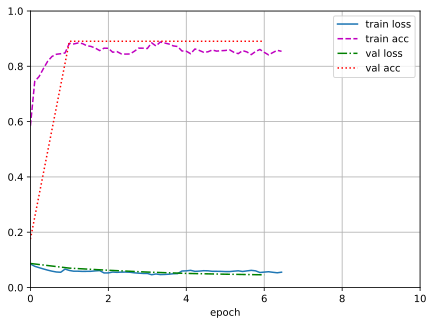

In [ ]:
!pip install d2l==0.14.2 -q
from d2l import torch as d2l
from collections import deque
from statistics import mean


def evaluate(net, validate_loader, loss_function):
  #You need to set the network to eval mode when using batch normalization (to
  #be consistent across evaluation samples, we use mean and stddev computed
  #during training when doing inference, as opposed to ones computed on the
  #batch) or dropout (you want to use all the parameters during inference).
  net.eval()  # Set the model to evaluation mode
  device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(4)
  #This line reduces the memory by not tracking the gradients. Also to be used
  #during inference.
  with torch.no_grad():
    for i, (inputs, GTs) in enumerate(validate_loader):
      #Send inputs and GTs them to the computation device (i.e. GPU). The GTs tensor
      #has to be converted to nn.LongTensor type (a type of integer) and turned into
      #a 3D tensor by removing dimension 1 with the squeeze() function.
      inputs = inputs.to(device)
      GTs = GTs.type(torch.long).squeeze().to(device)
      pred = network(inputs)
      # pred = pred[:,0,:,:].float()
      # print(pred[0,0,0], GTs[0,0,0])
      loss = loss_function(pred, GTs)
      overall_accuracy = (pred.max(1)[1]==GTs).float().mean()
      metric.add(loss, GTs.shape[0], overall_accuracy, 1)
  return metric


number_epochs = epochs

animator = d2l.Animator(xlabel='epoch', xlim=[0, number_epochs], ylim=[0, 1],
                        legend=['train loss', 'train acc', 'val loss', 'val acc'],
                        fmts=('-', 'm--', 'g-.', 'r:'),
                        figsize=(7, 5))

network = Hypercolumns()
network.to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=0.1)
#Training metrics are computed as a running average of the last x samples
loss_train = deque(maxlen=len(train_loader))
accuracy_train = deque(maxlen=len(train_loader))

for epoch in range(number_epochs):
  #Validation phase:
  metric_val = evaluate(network, val_loader, loss_function)
  animator.add(epoch,(None, None, metric_val[0]/metric_val[1], metric_val[2]/metric_val[3]))

  #Training phase:
  network.train() #indicate to the network that we enter training mode
  for i, (inputs, GTs) in enumerate(train_loader):
    inputs = inputs.to(device)
    GTs = GTs.type(torch.long).squeeze().to(device)
    #We set the gradients of the model to 0.
    optimizer.zero_grad()
    pred = network(inputs)
    loss = loss_function(pred, GTs)
    overall_accuracy = (pred.max(1)[1]==GTs).float().mean()
    #We accumulate the gradients...
    loss.backward()
    #...and we update the parameters according to the gradients.
    optimizer.step()
    loss_train.append(loss.item()/GTs.shape[0])
    accuracy_train.append(overall_accuracy.item())
    animator.add(epoch+i/len(train_loader),
                      (mean(loss_train), mean(accuracy_train), None, None))


  #After each training epoch, reduce the learning rate by a factor of 0.25
  optimizer.param_groups[0]['lr'] *= 0.25

metric_val = evaluate(network, val_loader, loss_function)
animator.add(epoch+1,(None, None, metric_val[0]/metric_val[1], metric_val[2]/metric_val[3]))


#Optional, if you want to save your model (you will need to use a folder where you have writing rights):
#torch.save(network.state_dict(), os.path.join(base_folder, 'WeightsVaihingen/', 'Hypercolumns_' + str(number_epochs) + "epochs.pth")
#torch.save(network.state_dict(), os.path.join(base_folder, 'WeightsVaihingen/', 'Hypercolumns_augm_weigths_' + str(number_epochs) + 'epochs.pth'))


In [ ]:
batch = next(iterable_train_loader)

pred = network(batch[1][0].to(device))

# print(loss_function(pred, batch[1][1].to(device)))
print('This is batch number '+ str(batch[0]))
fig, axs = plt.subplots(batch_size, 3)
fig.set_size_inches(15,5*batch_size)
for i in range(batch_size):
  axs[i,0].imshow(batch[1][0].permute(0,2,3,1)[i,:,:,:3])
  axs[i,1].imshow(batch[1][1][i,0,:,:],cmap=plt.get_cmap('gray'),vmin=0,vmax=1)
  axs[i,2].imshow(pred[i,:,:,:].max(0)[1].cpu(),cmap=plt.get_cmap('gray'))
axs[0,0].set_title('Image')
axs[0,1].set_title('GT')
axs[0,2].set_title('Prediction')